In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import numpy as np

from quantem.core.visualization import show_2d
from quantem.tomography.utils import rot_ZXZ

from quantem.tomography.tomography import Tomography
from quantem.core.ml.inr import HSiren
from quantem.tomography.object_models import ObjectINN

# Loading Phantom Volume
Cedric Lim, *12/5/2025*

**Note: Requires the tomography branch (TEMP)**

Loading the phantom volume

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

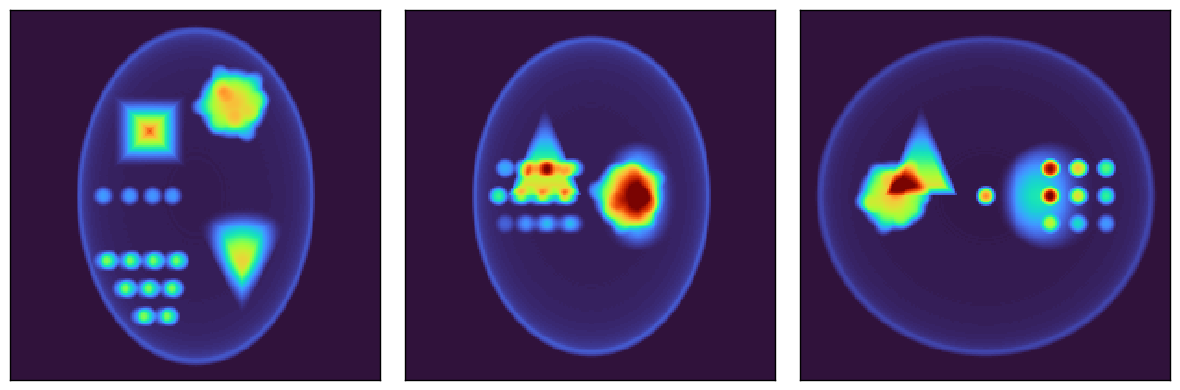

In [3]:
# Load phantom volume
device = 'cuda'
phantom_vol = torch.from_numpy(np.load('../data/phantom.npy')).type(torch.float32).to(device)

show_2d(
    [phantom_vol.sum(axis = 0),
     phantom_vol.sum(axis = 1),
     phantom_vol.sum(axis = 2)],
    cmap = 'turbo',
    vmin = 0,
    vmax = 50
)


## Simulate tilt series dataset

Create a tilt series dataset with a tilt step of 2 degrees, tilt range of (-60, 60). with a 2 degree systematic tilt axis error

In [4]:
tilt_step = 2
tilt_angles = torch.arange(-60, 61, tilt_step).type(torch.float32).to(device)
tilt_series = []
tilt_axis = 2

for tilt_angle in tilt_angles:
    tilt_series.append(rot_ZXZ(phantom_vol.unsqueeze(0), z1 = tilt_axis, x = tilt_angle, z3 = -tilt_axis, device = device).squeeze(0).sum(axis = 0))

tilt_series = torch.stack(tilt_series)
print("Tilt series shape: ", tilt_series.shape)

Tilt series shape:  torch.Size([61, 200, 200])


/home/cedlim/quantem/quantem/src/quantem/tomography/utils.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, device=device)


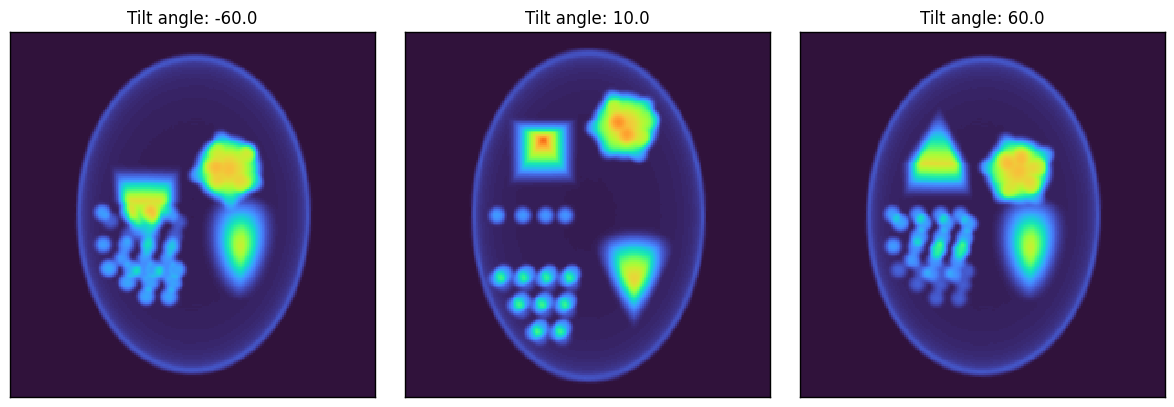

In [5]:
fig, ax = show_2d(
    [tilt_series[0], tilt_series[35], tilt_series[60]],
    titles = ['Tilt angle: {}'.format(tilt_angles[0]),
              'Tilt angle: {}'.format(tilt_angles[35]),
              'Tilt angle: {}'.format(tilt_angles[60])],
    cmap = 'turbo',
    vmin = 0,
    vmax = 50
)


# SIRT Reconstruction

Since most frameworks over complicate doing conventional algorithmic reconstructions, in quantEM we have simplified SIRT reconstructions while implementing additional features.

Workflow:
1. Instantiate the tomography class:
    - `tilt_series`: Tilt series stack.
    - `tilt_angles`: The predefined tilt angle/$\alpha$ tilts. (**BUG**: To match with ML reconstructions, the negative tilt angles must be inputted.)
2. Call `Tomography.sirt_recon`.
    - The only parameters that need to be defined is a `Tuple` of the volume shape, and the number of iterations.
    - Additional functionalities such as enforcing positivity, shrinkage, and cross-correlation inline alignment are also implemented.

In [21]:
# Initialize Tomography object.

tomo = Tomography.from_data(
    tilt_series = tilt_series,
    tilt_angles = -tilt_angles,
    device = device,
)

/home/cedlim/quantem/quantem/src/quantem/core/utils/validators.py:407: UserWarning: tilt_series is a torch tensor on device cuda:0. Converting to CPU numpy array.
  warn(
/home/cedlim/quantem/quantem/src/quantem/core/utils/validators.py:407: UserWarning: tilt_angles is a torch tensor on device cuda:0. Converting to CPU numpy array.
  warn(


SIRT Reconstruction:   0%|          | 0/10 [00:00<?, ?it/s]

Devices cuda:0 cuda:0 cuda:0


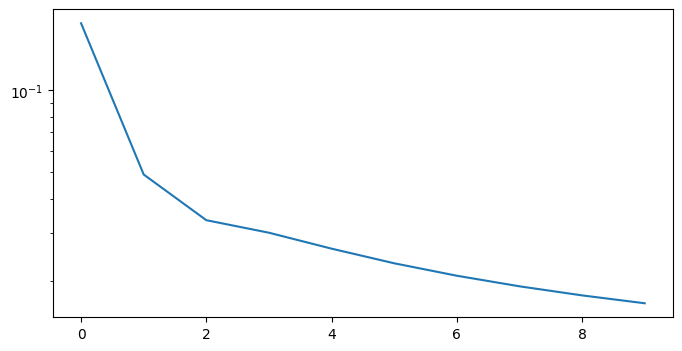

In [22]:
# Run SIRT reconstruction

tomo.sirt_recon(
    num_iterations = 10,
    inline_alignment = True,
    enforce_positivity = True,
    volume_shape = (200, 200, 200),
    reset = True,
    plot_loss = True,
)

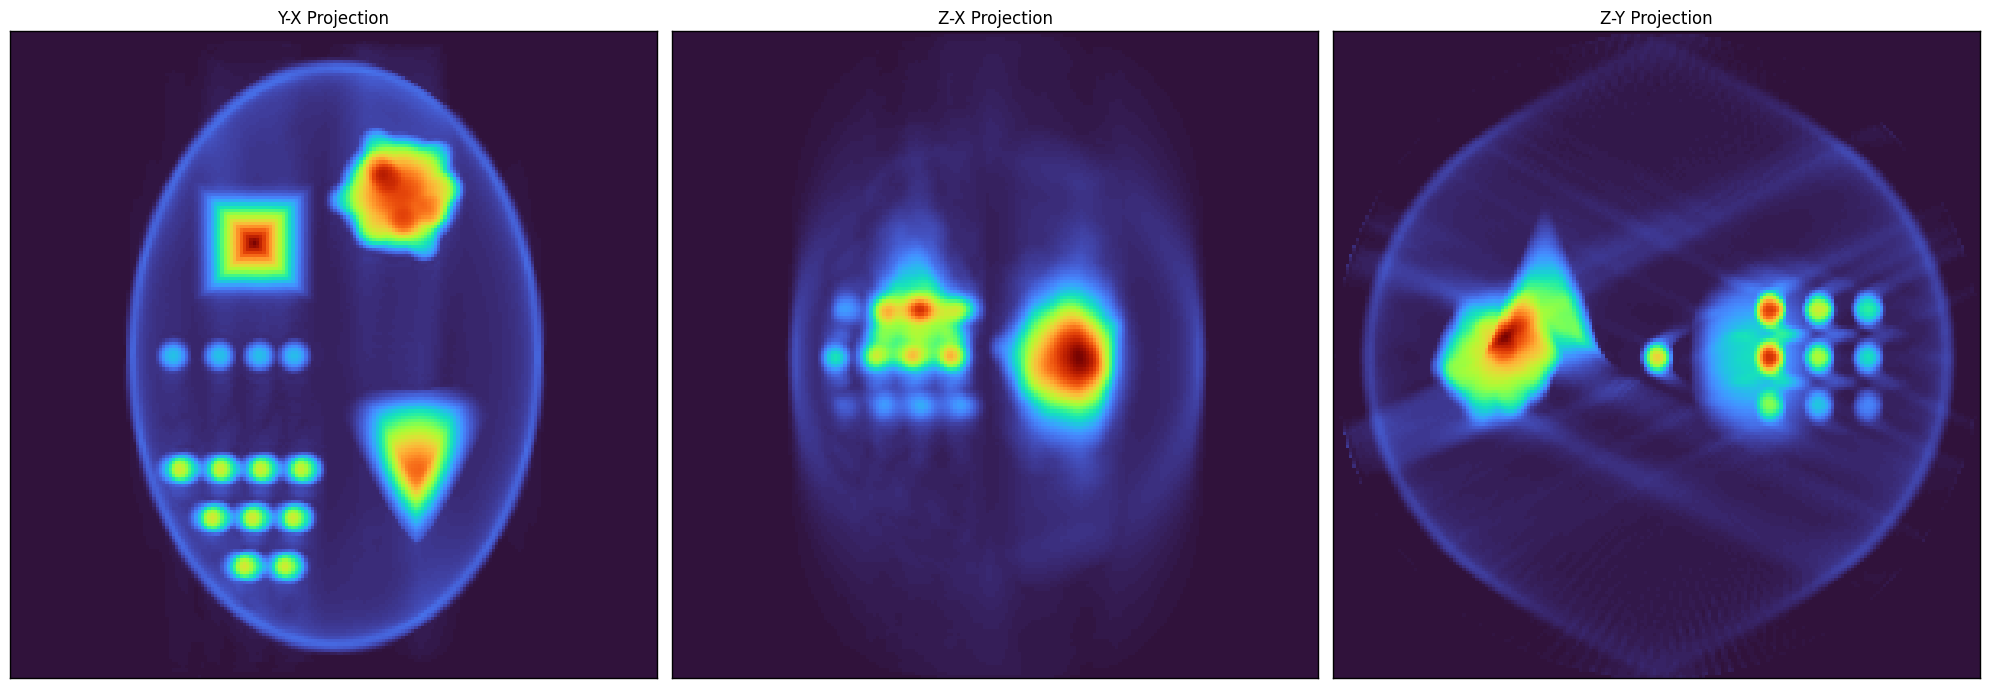

In [ ]:
# Visualization helper function

tomo.plot_projections()

# INR Reconstruction

Following the same design principles at our `Ptychography` module, the INR is built to be modular and highly customizable. Similar to the previous section, we instantiate the tomography class.

In [9]:
tomo = Tomography.from_data(
    tilt_series = tilt_series,
    tilt_angles = tilt_angles,
    # device = device,
)

# tomo.dataset.tilt_series

/home/cedlim/quantem/quantem/src/quantem/core/utils/validators.py:407: UserWarning: tilt_series is a torch tensor on device cuda:0. Converting to CPU numpy array.
  warn(
/home/cedlim/quantem/quantem/src/quantem/core/utils/validators.py:407: UserWarning: tilt_angles is a torch tensor on device cuda:0. Converting to CPU numpy array.
  warn(


## Reconstruction

The current general workflow for tomography reconstructions is as follows:

1. Define the consistency criterion/loss function. The following loss functions are available:
    - `smooth_l1`, `mse`, `l1`, `adpative_smooth_l1`, `charbonnier`, and `mse_log`
    - We currently recommend using `smooth_l1` with a $\beta=0.07$.
2. Define the choice of model architecture
    - Siren, HSiren, and Finer are implemented each with their own hyperparameters.
    - A predefined H-Siren model is given below as a baseline.
3. Create a `ObjectINN` class which handles the forward pass of the reconstruction loop.
4. Define the optimizer, and scheduler parameters.
5. Define the soft constraints such as total-variational loss.
6. Call `Tomography.recon`.

The next cell below is the warm-up section for letting the model get a rough shape of the volume by scaling the number of sample points per ray. We recommend 10 epochs of warmup, prior to doing full optimization of the poses.

In [ ]:
consistency_criterion = ("smooth_l1", 0.07) # Defining the loss function


# Instantiate the model
model = HSiren(
    in_features = 3,
    out_features = 1,
    hidden_layers = 4,
    hidden_features = 512,
    first_omega_0 = 30,
    alpha = 1.0,
    r_first_layer = 2,
    r_hidden_layers = 2,
)

# Pass the model to the ObjectINN class with the volume shape, and device name.
obj = ObjectINN(
    model = model,
    volume_shape = (200, 200, 200),
    device = device,
)

# Warm-up

epochs = 10
optimizer_params = {
    "model": {
        "type": "adam",
        "lr": 8e-6,
    }
}

scheduler_params = {
    "model" : {
        "type": "linear",
        "start_factor": 0.01,
        "total_iters": epochs,
    }
}

# Define the soft constraints
soft_constraints = {
    "tv_vol": 1e-4,
}


In [ ]:

tomo.recon(
    obj = obj,
    batch_size = 4096,
    num_workers = 0,
    epochs = epochs,
    optimizer_params = optimizer_params,
    scheduler_params = scheduler_params,
    soft_constraints = soft_constraints,
    vol_save_path = "runs/vols",
    log_path = "runs/logs",
    val_fraction = 0.0,
    learn_shifts = False,
    consistency_criterion = consistency_criterion,
    force_cpu = False,
    viz_freq = 5
)

Single GPU training
Model built, compiled successfully
Dataloader setup complete:
  Total projections: 61
  Grid size: 200200
  Total pixels: 2,440,000
  Local batch size (train): 4096
  Global batch size: 4096
  Train batches per GPU per epoch: 595
Using projection 30 (angle=0.00°) as reference
Using consistency criterion: ('smooth_l1', 0.07)
Epoch 0: num_samples_per_ray = 20
Epoch 1: num_samples_per_ray = 20
Epoch 2: num_samples_per_ray = 100
Epoch 2: Changing num_samples_per_ray from 20 to 100
Epoch 3: num_samples_per_ray = 100
Epoch 4: num_samples_per_ray = 100
Epoch 5: num_samples_per_ray = 150
Epoch 5: Changing num_samples_per_ray from 100 to 150
Epoch 6: num_samples_per_ray = 150
Epoch 7: num_samples_per_ray = 200
Epoch 7: Changing num_samples_per_ray from 150 to 200
Epoch 8: num_samples_per_ray = 200
Epoch 9: num_samples_per_ray = 200
Training complete.


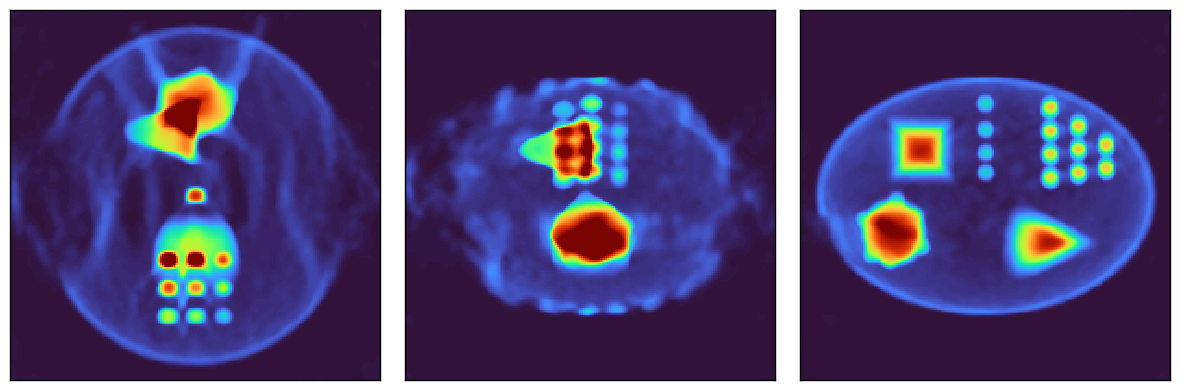

In [12]:
fig, ax = show_2d(
    [obj.obj.sum(axis = 0).cpu().numpy(),
     obj.obj.sum(axis = 1).cpu().numpy(),
     obj.obj.sum(axis = 2).cpu().numpy()],
    cmap = 'turbo',
    vmin = 0,
    vmax = 250
)

Next we instantiate the optimizer for the auxiliary parameters, i.e the for the poses. Then we call again `Tomography.recon`.

In [13]:
# Begin Pose Optimization

epochs = 90

print("Adding aux optimizer")
tomo._add_optimizer(
    "aux_params",
    tomo.dataset.auxiliary_params.parameters(),
    {
        "type": "adam",
        # "lr": 1.5e-5,
        "lr": 5e-2,
    }
)
scheduler_params = {
    "aux_params": {
        "type": "cosine_annealing",
        "T_max": epochs,
    },
    "model": {
        "type": "cosine_annealing",
        "T_max": epochs,
    }
}

tomo.recon(
    obj = obj,
    batch_size = 1024,
    num_workers = 0,
    scheduler_params = scheduler_params,
    epochs = epochs,
    soft_constraints = soft_constraints,
    viz_freq = 5,
    vol_save_path = "runs/vols",
    log_path = "runs/logs",
    consistency_criterion = consistency_criterion,
    # model_weights_path = log_path / "model_weights.pth",
)


Adding aux optimizer
Using projection 30 (angle=0.00°) as reference
Using consistency criterion: ('smooth_l1', 0.07)
Auxiliary params already set
Epoch 0: num_samples_per_ray = 200
Epoch 1: num_samples_per_ray = 200
Epoch 2: num_samples_per_ray = 200
Epoch 3: num_samples_per_ray = 200
Epoch 4: num_samples_per_ray = 200
Epoch 5: num_samples_per_ray = 200
Epoch 6: num_samples_per_ray = 200
Epoch 7: num_samples_per_ray = 200
Epoch 8: num_samples_per_ray = 200
Epoch 9: num_samples_per_ray = 200
Epoch 10: num_samples_per_ray = 200
Epoch 11: num_samples_per_ray = 200
Epoch 12: num_samples_per_ray = 200
Epoch 13: num_samples_per_ray = 200
Epoch 14: num_samples_per_ray = 200
Epoch 15: num_samples_per_ray = 200
Epoch 16: num_samples_per_ray = 200
Epoch 17: num_samples_per_ray = 200
Epoch 18: num_samples_per_ray = 200
Epoch 19: num_samples_per_ray = 200
Epoch 20: num_samples_per_ray = 200
Epoch 21: num_samples_per_ray = 200
Epoch 22: num_samples_per_ray = 200
Epoch 23: num_samples_per_ray = 200


In [ ]:
recon_vol = obj.obj.detach().cpu().numpy().transpose(2, 1, 0) #TODO: Fix the orientation of the volume

In [ ]:
# Normalizing both SIRT and INR volumes
recon_vol/= recon_vol.max() 
sirt_recon_vol = tomo.sirt_recon_vol.obj/tomo.sirt_recon_vol.obj.max()

SSIM (INR): 0.9496969490287591
SSIM (SIRT): 0.883921224092619


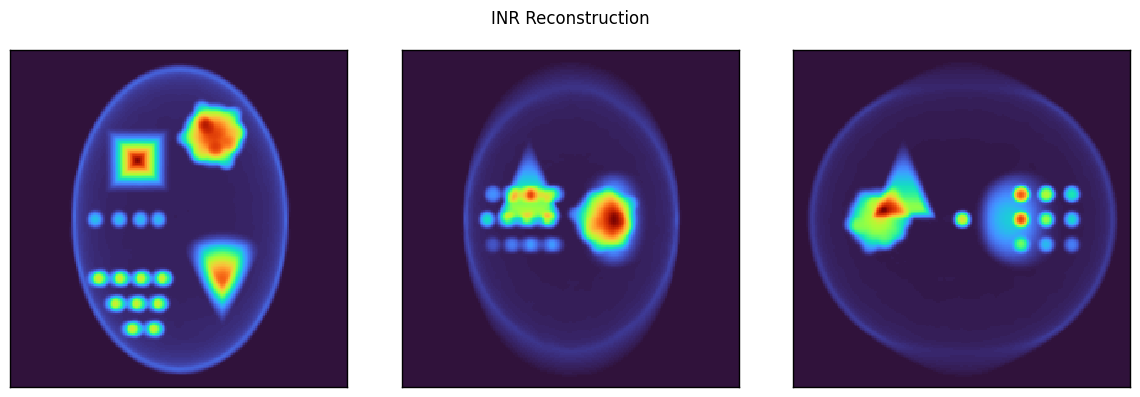

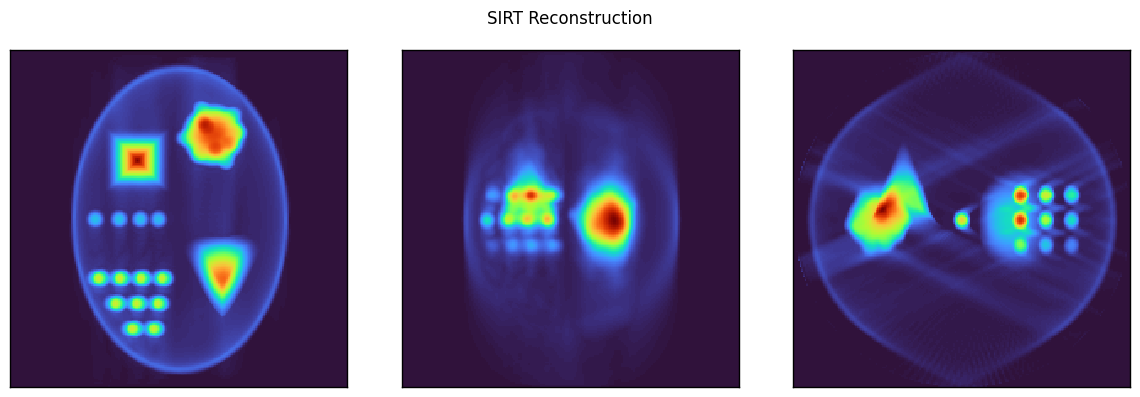

In [54]:
# Show Metrics

from skimage.metrics import structural_similarity as ssim

gt_slice = phantom_vol[:, :, 100].detach().cpu().numpy()
inr_slice = recon_vol[:, :, 100]
sirt_slice = sirt_recon_vol[:, :, 100].detach().cpu().numpy()


ssim_inr = ssim(inr_slice, gt_slice, data_range = inr_slice.max())
ssim_sirt = ssim(sirt_slice, gt_slice, data_range = sirt_slice.max())

print(f"SSIM (INR): {ssim_inr}")
print(f"SSIM (SIRT): {ssim_sirt}")

fig, ax = show_2d(
    [recon_vol.sum(axis = 0),
     recon_vol.sum(axis = 1),
     recon_vol.sum(axis = 2)],
    cmap = 'turbo',
    vmin = 0,
    # vmax = 250
)
fig.suptitle("INR Reconstruction")
fig.tight_layout()
fig, ax = show_2d(
    [sirt_recon_vol.sum(axis = 0),
     sirt_recon_vol.sum(axis = 1),
     sirt_recon_vol.sum(axis = 2)],
    cmap = 'turbo',
    vmin = 0,
    # vmax = 250
)
fig.suptitle("SIRT Reconstruction")
fig.tight_layout()

#

# Loading Tensorboard

When the ML reconstruction is used a Tensorboard logging file is automatically generated. All data visualization, and loss curves can be seen below.

In [55]:
%load_ext tensorboard
%tensorboard --logdir runs/logs/
print(f"TensorBoard will be available at: http://localhost:6006")


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


TensorBoard will be available at: http://localhost:6006
